In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [ ]:
X, y = mnist.data, mnist.target

In [ ]:
print(X.shape, y.shape)

(70000, 784) (70000,)


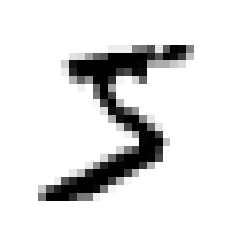

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

plot_digit(X[0])
plt.show()

In [ ]:
threshold = 60_000
X_train, X_test, y_train, y_test = X[:threshold], X[threshold:], y[:threshold], y[threshold:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knc_clf = KNeighborsClassifier(n_neighbors=3)
knc_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
test_digit, test_digit_label = X_test[4], y_test[4]
pred = knc_clf.predict([test_digit])
print(pred, test_digit_label)

['4'] 4


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(knc_clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.91511698, 0.94059406, 0.95919592])

In [ ]:
from sklearn.model_selection import cross_val_predict
y_test_pred = cross_val_predict(knc_clf, X_test, y_test, cv=3)

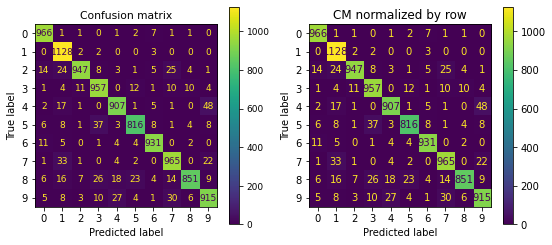

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knc_clf.classes_)
disp.plot(ax=axs[0])
axs[0].set_title("Confusion matrix")

cm_n = confusion_matrix(y_test, y_test_pred, normalize="true")
plt.rc('font', size=10)
disp_n = ConfusionMatrixDisplay(confusion_matrix=cm_n, display_labels=knc_clf.classes_)
disp.plot(ax=axs[1])
axs[1].set_title("CM normalized by row")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_test_pred, average="macro"), recall_score(y_test, y_test_pred, average="macro")

(0.939852616320343, 0.9374218080674253)

In [ ]:
from sklearn.model_selection import GridSearchCV
knc_clf_v2 = KNeighborsClassifier(n_neighbors=3)
param_grid = {"weights": ["uniform", "distance"],
              "n_neighbors": [i for i in range(3, 8)]}

gs = GridSearchCV(knc_clf_v2, cv=3, param_grid=param_grid, scoring="accuracy", verbose=2)
gs.fit(X_train, y_train)

In [ ]:
best_estimator = gs.best_estimator_

In [ ]:
gs.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
cross_val_score(best_estimator, X_test, y_test, cv=3, scoring="accuracy")

array([0.91841632, 0.9429943 , 0.96189619])

In [ ]:
knn_best = KNeighborsClassifier(n_neighbors=gs.best_params_["n_neighbors"], weights = gs.best_params_["weights"])
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
cross_val_score(knn_best, X_test, y_test, cv=3, scoring="accuracy")

array([0.91841632, 0.9429943 , 0.96189619])

In [50]:
from sklearn.metrics import accuracy_score
y_pred = knn_best.predict(X_test)
accuracy_score(y_pred, y_test)

0.9714

In [53]:
pred_proba = knn_best.predict_proba(X_test)

In [69]:
import sys
print(sys.version)

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


In [81]:
import numpy as np

def shift_augmetation(img_in: np.ndarray, shift: int = 1, dir="r", reshape: bool = True):
  img = img_in.copy().reshape(int(np.sqrt(img_in.shape[0])),
                               (int(np.sqrt(img_in.shape[0]))))
  
  shifted_img = np.zeros(img.shape)
  if dir == "r":
    shifted_img[:, shift:] = img[:, :-shift]
  elif dir == "l":
    shifted_img[:, :-shift] = img[:, shift:]
  elif dir == "d":
    shifted_img[shift:, :] = img[:-shift, :]
  elif dir == "u":
    shifted_img[:-shift, :] = img[shift:, :]

  if reshape:
    return shifted_img.reshape(img_in.shape[0])
  else:
    return shifted_img


In [78]:
X.shape

(70000, 784)

In [113]:
X_aug_t = np.zeros((X_train.shape[0] * 5, X_train.shape[1]))
y_aug_t = np.zeros(X_train.shape[0] * 5)
for i, sample in enumerate(X_train):
  X_aug_t[i * 5] = sample
  X_aug_t[i * 5 + 1] = shift_augmetation(sample, dir="r", shift = 1)
  X_aug_t[i * 5 + 2] = shift_augmetation(sample, dir="l", shift = 1)
  X_aug_t[i * 5 + 3] = shift_augmetation(sample, dir="u", shift = 1)
  X_aug_t[i * 5 + 4] = shift_augmetation(sample, dir="d", shift = 1)

  y_aug_t[i * 5] = y_aug_t[i * 5 + 1] = y_aug_t[i * 5 + 2] = y_aug_t[i * 5 + 3] = y_aug_t[i * 5 + 4] = y_train[i]

In [114]:
knn_best_aug = KNeighborsClassifier(n_neighbors=gs.best_params_["n_neighbors"], weights = gs.best_params_["weights"])
knn_best_aug.fit(X_aug_t, y_aug_t)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [115]:
y_pred_aug = knn_best_aug.predict(X_test)

In [116]:
accuracy_score(np.asarray(np.asarray(y_pred_aug, dtype=np.int), dtype=np.str), y_test)

<ipython-input-116-37ea731113a4>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracy_score(np.asarray(np.asarray(y_pred_aug, dtype=np.int), dtype=np.str), y_test)
<ipython-input-116-37ea731113a4>:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

0.9763

<ipython-input-119-fd9a89540c6c>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = confusion_matrix(np.asarray(y_test, dtype=np.int), np.asarray(y_pred_aug, dtype=np.int))


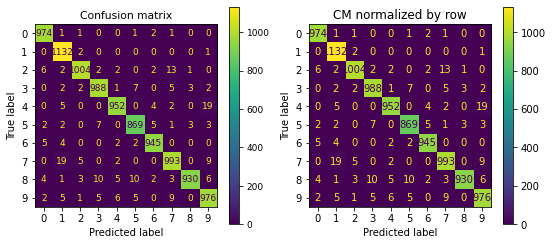

In [119]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.asarray(y_test, dtype=np.int), np.asarray(y_pred_aug, dtype=np.int))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knc_clf.classes_)
disp.plot(ax=axs[0])
axs[0].set_title("Confusion matrix")

cm_n = confusion_matrix(y_test, y_test_pred, normalize="true")
plt.rc('font', size=10)
disp_n = ConfusionMatrixDisplay(confusion_matrix=cm_n, display_labels=knc_clf.classes_)
disp.plot(ax=axs[1])
axs[1].set_title("CM normalized by row")
plt.show()

In [120]:
error_rate_change = (1 - accuracy_score(np.asarray(np.asarray(y_pred_aug, dtype=np.int), dtype=np.str), y_test)) / (1 - accuracy_score(y_pred, y_test)) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


<ipython-input-120-6fc4b0e47084>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error_rate_change = (1 - accuracy_score(np.asarray(np.asarray(y_pred_aug, dtype=np.int), dtype=np.str), y_test)) / (1 - accuracy_score(y_pred, y_test)) - 1
<ipython-input-120-6fc4b0e47084>:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more 